<a href="https://colab.research.google.com/github/at19990/sports_analytics/blob/master/p03-regression-basketball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# バスケットボールのスタッツを回帰分析

Bリーグのスタッツを取得し、各変数の相関を観察したのち、回帰による予測モデルを作成する

In [1]:
# 必要なパッケージのインストール
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 3s (72.5 kB/s)
Reading package lists... Done
Reading package lists... Done
Building 

In [0]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc

import scipy.stats as sp
from scipy.stats import norm

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

In [0]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

## データの取得・整形

Basketballnavi.DB([https://stats.basketballnavi.com/player_leaders_2019.pl](https://stats.basketballnavi.com/player_leaders_2019.pl)) から2019-2020シーズンのBリーグのプレイヤースタッツ順位表を取得し、整形する

In [0]:
# seleniumを用いてスクリプト適用後のページソースを取得
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=options)
driver.implicitly_wait(10)
driver.get("https://stats.basketballnavi.com/player_leaders_2019.pl")
html = driver.page_source.encode('utf-8')
soup = BeautifulSoup(html, "html.parser")

In [5]:
# スクレイピングしたHTMLから表を抽出
fetched_dataframes = pd.io.html.read_html(html)
df = fetched_dataframes[0]
# 欠損値・不要な行の処理・ソート
df = df[~df['#'].str.contains('NO')]
df = df.dropna()
df = df.loc[:,'G':'PF'].astype('float64').sort_values('BLK')
# インデックスの振り直し
df = df.reset_index(drop=True)
df

,G,GS,MP,PTS,3PM,3PA,3P%,FGM,FGA,FG%,FTM,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
0,12.0,8.0,22.9,4.1,7.0,30.0,23.3,19.0,56.0,33.9,4.0,6.0,66.7,0.2,2.7,3.8,1.0,0.0,2.0,1.8
1,14.0,14.0,23.9,9.8,14.0,34.0,41.2,51.0,108.0,47.2,21.0,27.0,77.8,1.1,2.8,5.4,1.2,0.0,2.0,1.8
2,12.0,9.0,28.5,13.5,21.0,63.0,33.3,61.0,141.0,43.3,19.0,23.0,82.6,0.4,2.8,4.5,1.0,0.0,1.2,1.9
3,13.0,12.0,19.6,6.0,8.0,39.0,20.5,27.0,78.0,34.6,16.0,18.0,88.9,0.5,1.9,1.1,0.8,0.0,1.3,1.9
4,10.0,1.0,19.8,3.9,11.0,23.0,47.8,13.0,29.0,44.8,2.0,3.0,66.7,0.2,2.0,1.0,0.1,0.0,0.7,2.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,9.0,9.0,31.3,14.6,15.0,42.0,35.7,49.0,109.0,45.0,18.0,28.0,64.3,2.4,7.3,1.4,1.2,1.6,1.9,2.8
151,9.0,9.0,35.1,20.2,3.0,10.0,30.0,75.0,135.0,55.6,29.0,37.0,78.4,5.2,11.4,2.4,1.3,1.6,2.6,2.3
152,9.0,9.0,33.8,17.2,2.0,12.0,16.7,63.0,122.0,51.6,27.0,38.0,71.1,1.6,11.8,3.0,1.6,1.8,2.8,2.8
153,14.0,14.0,36.3,24.1,8.0,22.0,36.4,141.0,265.0,53.2,48.0,72.0,66.7,1.9,9.7,3.5,1.5,1.9,2.9,2.1


## 2変数を選択し、散布図を描画

試しに、**FG%** (2ポイント・3ポイントシュートの成功率) と **FT%** (フリースローの成功率) をプロットし、相関を観察する

In [0]:
# 浮動小数点の配列に変換
array_fgp = df['FG%'].values.astype(np.float)
array_ftp = df['FT%'].values.astype(np.float)

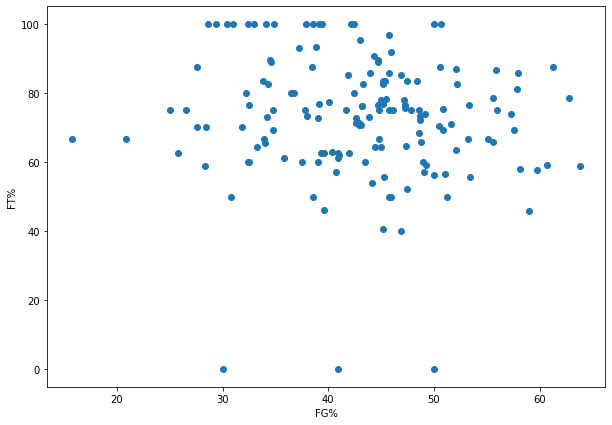

In [7]:
# 散布図描画
plt.figure(figsize=(10, 7))

plt.scatter(array_fgp, array_ftp)
plt.xlabel('FG%')
plt.ylabel('FT%')

plt.show()

→ 相関はみられなかった

## ヒートマップの作成

各変数の相関を可視化するため、ヒートマップを作成する

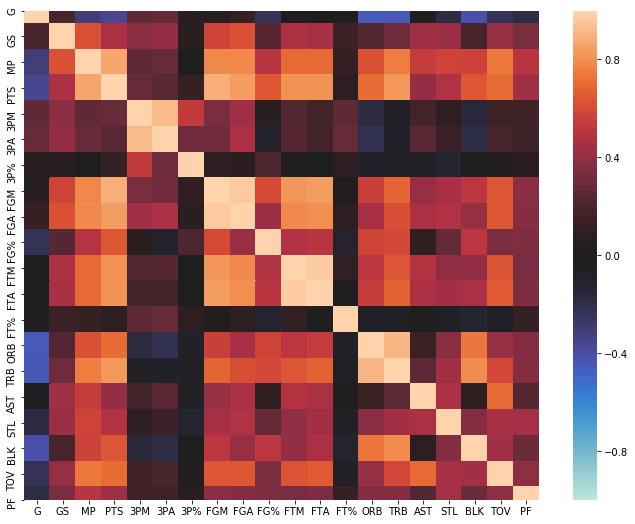

In [8]:
fig2, ax2 = plt.subplots(figsize=(12, 9)) 
df_corr = df.corr()
sns.heatmap(df_corr, square=True, vmax=1, vmin=-1, center=0)
fig2.show()

## 回帰分析の実施

ヒートマップを観察した結果、**BLK** (平均ブロック数) と **ORB** (平均オフェンスリバウンド数) には一定の相関があることがわかった

→ pythonのパッケージであるsklearnを使用し、回帰による予測モデルを作成する

In [0]:
# 各列を数列に変換し、sklearnで使用可能な形に整える
array_blk = df['BLK'].values.astype(np.float).reshape(-1, 1)
array_blk_2 = df['BLK'].values.astype(np.float)

array_orb = df['ORB'].values.astype(np.float)

### 単回帰

説明変数を1つ持つ線形回帰モデルによって、直線 ( $y = bx + a$ ) で表現する



In [10]:
# モデル作成
reg_lin = linear_model.LinearRegression()
reg_lin.fit(array_blk, array_orb)
# 式と誤差の出力
print("[ORB] = {0} * (BLK) + {1}".format(reg_lin.coef_, reg_lin.intercept_))
print("(線形回帰のRMSE) = {0}".format(np.sqrt(mean_squared_error(array_orb, reg_lin.predict(array_blk)))))

[ORB] = [1.81235732] * (BLK) + 0.49750487491677
(線形回帰のRMSE) = 0.7679848632274702


### 多項式回帰

説明変数は1つのまま、次数を上げた回帰モデルによって、曲線 ( $y = b_0 + b_1x + b_2x^2 + \dots + b_px^p  $ ) で表現する

In [11]:
# BLKの各値を1～4乗した配列に変換
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4, include_bias=False)
array_blk_new = poly.fit_transform(array_blk)
# 最後の3レコードを出力(各項が[1乗, 2乗, 3乗, 4乗]の形になっていることを確認)
array_blk_new[-3:]

array([[ 1.8   ,  3.24  ,  5.832 , 10.4976],
       [ 1.9   ,  3.61  ,  6.859 , 13.0321],
       [ 2.3   ,  5.29  , 12.167 , 27.9841]])

In [12]:
# モデル作成
reg_lin_2 = linear_model.LinearRegression()
reg_lin_2.fit(array_blk_new, array_orb)
# 式と誤差の出力
print("[ORB] = {0} + {1}*(BLK) + {2}*(BLK)^2 + {3}*(BLK)^3 + {4}*(BLK)^4".format(reg_lin_2.intercept_, reg_lin_2.coef_[0], reg_lin_2.coef_[1], reg_lin_2.coef_[2], reg_lin_2.coef_[3]))
print("(多項式回帰のRMSE) = {0}".format(np.sqrt(mean_squared_error(array_orb, reg_lin_2.predict(array_blk_new)))))

[ORB] = 0.39920373672139586 + 1.7412271639581631*(BLK) + 3.6388008355575745*(BLK)^2 + -4.115920167196315*(BLK)^3 + 1.086485223854575*(BLK)^4
(多項式回帰のRMSE) = 0.7266904855901497


### SVR (サポートベクター回帰)

誤差と重み (を2乗して0.5倍したもの) の和を最小化する

このとき、誤差関数に線形回帰で用いたよ二乗誤差のかわりにヒンジ関数を用いる (誤差が $\pm \epsilon$ の範囲に収まっているとき、誤差0として扱う) のが特徴

In [13]:
# モデル作成
reg_svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
reg_svr_rbf.fit(array_blk, array_orb)
# 誤差の出力
print("(SVRのRMSE) = {0}".format(np.sqrt(mean_squared_error(array_orb, reg_svr_rbf.predict(array_blk)))))

(SVRのRMSE) = 0.7516613267409353


### Ridge回帰

二乗誤差に学習した重みの二乗の$\alpha$倍を加え、それを最小化することによって、誤差を小さくしつつ重みの大きさも抑え、過学習を防ぐ

In [14]:
# モデルの生成・フィット
poly_2 = PolynomialFeatures(degree=8) # 1～8乗までもたせる
reg_ridge = Ridge(alpha=5, max_iter=10000)
reg_ridge_pl = Pipeline([("poly_8", poly_2), ("ridge", reg_ridge)])
reg_ridge_pl.fit(array_blk, array_orb)
# 誤差の出力
print("(Ridge回帰のRMSE) = {0}".format(np.sqrt(mean_squared_error(array_orb, reg_ridge_pl.predict(array_blk)))))

(Ridge回帰のRMSE) = 0.7414089875329093


## グラフに描画

実データと各モデルを用いた予測結果をグラフにプロットする

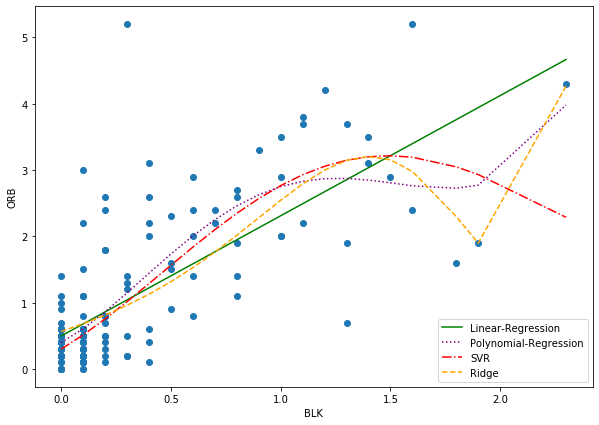

In [15]:
plt.figure(figsize=(10, 7))
plt.scatter(array_blk_2, array_orb)
plt.plot(array_blk, reg_lin.predict(array_blk), color='green', label='Linear-Regression', linestyle='solid')
plt.plot(array_blk, reg_lin_2.predict(array_blk_new),color='purple', label='Polynomial-Regression', linestyle='dotted')
plt.plot(array_blk, reg_svr_rbf.predict(array_blk), color='red', label='SVR', linestyle='dashdot')
plt.plot(array_blk, reg_ridge_pl.predict(array_blk), color='orange', label='Ridge', linestyle='dashed')
plt.xlabel("BLK")
plt.ylabel("ORB")
plt.legend()
plt.show()
